# Стохастический градиентный и координатный спуски

Для каждого задания указано количество баллов (если они оцениваются отдельно) + 1 балл за аккуратное и полное выполнение всего задания

## Загрузка и подготовка данных

**Загрузите уже знакомый вам файл *Advertising.csv* как объект DataFrame.** 

In [40]:
import numpy as np
import pandas as pd

df = pd.read_csv('data/Advertising.csv')
df.head()

,Unnamed: 0,TV,radio,newspaper,sales
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3
3,4,151.5,41.3,58.5,18.5
4,5,180.8,10.8,58.4,12.9


**Проверьте, есть ли в данных пропуски и, если они есть - удалите их**

In [41]:
df.isnull().sum()

Unnamed: 0    0
TV            0
radio         0
newspaper     0
sales         0
dtype: int64

Пропусков в данных нет

**Преобразуйте ваши признаки в массивы NumPy и разделите их на переменные X (предикторы) и y(целевая переменная)** 

In [42]:
X = df[['TV', 'radio', 'newspaper']]
X = np.array(X)
y = df[['sales']]
y = np.array(y)

## Координатный спуск (3 балла)

**Добавим единичный столбец для того, чтобы у нас был свободный коэффициент в уравнении регрессии:**

In [43]:
X = np.hstack([np.ones(X.shape[0]).reshape(-1, 1), X])

**Нормализуем данные: обычно это необходимо для корректной работы алгоритма**

In [44]:
X = X / np.sqrt(np.sum(np.square(X), axis=0))

**Реализуйте алгоритм координатного спуска:** (3 балла)

Ниже приведен алгоритм:

<a href="https://ibb.co/Th3BQFn"><img src="https://i.ibb.co/DK2DBS6/zascas.jpg" alt="zascas" border="0"></a>

Примечание: 1000 итераций здесь указаны для этого задания, на самом деле их может быть намного больше, нет детерменированного значения.

Вам необходимо реализовать координатный спуск, и вывести веса в модели линейной регрессии.

In [45]:
w = np.zeros((X.shape[1], 1))
for iter in range(1000):
    r = y - X@w
    for i in range(len(w)):
        A = X[:, i]*w[i]
        A = np.expand_dims(A, 1)
        r = r + A
        
        w[i] = X[:, i]@r
        A = X[:, i]*w[i]
        A = np.expand_dims(A, 1)
        r = r - A
w = w.T      
print(w)

[[ 41.56217205 110.13144155  73.52860638  -0.55006384]]


Сравните результаты с реализацией линейной регрессии из библиотеки sklearn:

In [46]:
from sklearn.linear_model import LinearRegression
 
model = LinearRegression(fit_intercept=False)
model.fit(X, y)
 
print(model.coef_)

[[ 41.56217205 110.13144155  73.52860638  -0.55006384]]


Если вы все сделали верно, они должны практически совпасть!

## Стохастический градиентный спуск (6 баллов)

**Отмасштабируйте столбцы исходной матрицы *X* (которую мы не нормализовали еще!). Для того, чтобы это сделать, надо вычесть из каждого значения среднее и разделить на стандартное отклонение** (0.5 баллов)

In [47]:
X = df[['TV', 'radio', 'newspaper']]
X = np.array(X)
for i in range(X.shape[1]):
    X[:,i] = (X[:,i] - np.mean(X[:,i]))/np.std(X[:,i])


**Добавим единичный столбец**

In [48]:
X = np.hstack([np.ones(X.shape[0]).reshape(-1, 1), X])

**Создайте функцию mse_error для вычисления среднеквадратичной ошибки, принимающую два аргумента: реальные значения и предсказывающие, и возвращающую значение mse** (0.5 балла)

In [49]:
def mse_error(y, y_pred):
    return np.sum((y - y_pred)**2)/y.shape[0]

**Сделайте наивный прогноз: предскажите продажи средним значением. После этого рассчитайте среднеквадратичную ошибку для этого прогноза** (0.5 балла)

In [50]:
y_pred = np.full((y.shape[0], 1), np.mean(y))

print(mse_error(y, y_pred))

27.085743750000002


**Создайте функцию *lin_pred*, которая может по матрице предикторов *X* и вектору весов линейной модели *w* получить вектор прогнозов** (0.5 балла)

In [51]:
def lin_pred(X, w):
    return X@w.T 

**Создайте функцию *stoch_grad_step* для реализации шага стохастического градиентного спуска. (1.5 балла) 
Функция должна принимать на вход следующие аргументы:**
* матрицу *X*
* вектора *y* и *w*
* число *train_ind* - индекс объекта обучающей выборки (строки матрицы *X*), по которому считается изменение весов
* число *$\eta$* (eta) - шаг градиентного спуска

Результатом будет вектор обновленных весов

Шаг для стохастического градиентного спуска выглядит следующим образом:

$$\Large w_j \leftarrow w_j - \frac{2\eta}{\ell} \sum_{i=1}^\ell{{x_{ij}((w_0 + w_1x_{i1} + w_2x_{i2} +  w_3x_{i3}) - y_i)}}$$

Для того, чтобы написать функцию, нужно сделать следующее:
    
*  посчитать направление изменения: умножить объект обучающей выборки на 2 и на разницу между предсказанным значением и реальным, а потом поделить на количество элементов в выборке.
* вернуть разницу между вектором весов и направлением изменения, умноженным на шаг градиентного спуска

In [52]:
def stoch_grad_step(X, y, w, train_ind, eta):
    X_cur = X[train_ind]
    y_pred_cur = lin_pred(X_cur, w)
    loss = y_pred_cur[0] - y[train_ind][0]
    w_new = []
    for i in range(w.shape[1]):
        w_new.append(w[0][i] - 2*eta*X_cur[i]*loss)

    return np.array([w_new])  

**Создайте функцию *stochastic_gradient_descent*, для реализации стохастического градиентного спуска (2.5 балла)**

**Функция принимает на вход следующие аргументы:**
- Матрицу признаков X
- Целевую переменнную
- Изначальную точку (веса модели)
- Параметр, определяющий темп обучения
- Максимальное число итераций
- Евклидово расстояние между векторами весов на соседних итерациях градиентного спуска,при котором алгоритм прекращает работу 

**На каждой итерации в вектор (список) должно записываться текущее значение среднеквадратичной ошибки. Функция должна возвращать вектор весов $w$, а также вектор (список) ошибок.**

Алгоритм сследующий:
    
* Инициализируйте расстояние между векторами весов на соседних итерациях большим числом (можно бесконечностью)
* Создайте пустой список для фиксации ошибок
* Создайте счетчик итераций
* Реализуйте оновной цикл обучения пока расстояние между векторами весов больше того, при котором надо прекратить работу (когда расстояния станут слишком маленькими - значит, мы застряли в одном месте) и количество итераций меньше максимально разрешенного: сгенерируйте случайный индекс, запишите текущую ошибку в вектор ошибок, запишите в переменную текущий шаг стохастического спуска с использованием функции, написанной ранее. Далее рассчитайте текущее расстояние между векторами весов и прибавьте к счетчику итераций 1.
* Верните вектор весов и вектор ошибок

In [53]:
#Функции минимизации ошибки методом стохастического градиентного спуска
def stochastic_gradient_descent(X, y, w0, eta, max_iter, min_dist=1e-6):
    #расстояние между векторами весов на соседних итерациях
    dist = np.inf
    #вектор ошибок
    errors = []
    #Счетчик итераций
    iter = 0
    w = w0
    while dist > min_dist and iter < max_iter:
        random_index = np.random.randint(X.shape[0])
        w_new = stoch_grad_step(X, y, w, random_index, eta)
        dist = np.linalg.norm(w_new - w)
        y_pred = lin_pred(X, w_new)
        errors.append(mse_error(y, y_pred))
        w = w_new
        iter += 1
    return w, errors



 **Запустите $10^5$ итераций стохастического градиентного спуска. Укажите вектор начальных весов, состоящий из нулей. Можете поэкспериментировать с параметром, отвечающим за темп обучения.**

**Постройте график зависимости ошибки от номера итерации**

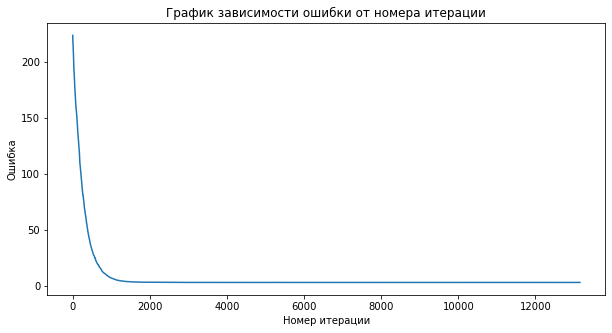

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Рассчитываем веса и ошибки на каждой итерации
w_result, errors = stochastic_gradient_descent(X, y, np.array([[0, 0, 0, 0]]), 0.001, 100000)

#Строим график ошибок
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(data=errors, ax=ax)
ax.set_title('График зависимости ошибки от номера итерации')
ax.set_xlabel('Номер итерации')
ax.set_ylabel('Ошибка')
plt.show()


**Выведите вектор весов, к которому сошелся метод.**

In [55]:
print('Вектор весов',w_result)

Вектор весов [[ 1.41049079e+01  3.83937211e+00  2.83285150e+00 -2.34611655e-04]]


**Выведите среднеквадратичную ошибку на последней итерации.**

In [56]:
y_pred = lin_pred(X, w_result)
print('MSE - ', mse_error(y_pred, y))

MSE -  2.7995449037455593


In [3]:
from sklearn import metrics
import numpy as np
y_true = [1.23, 2.35, 2.75]
y_pred = [1.01, 12.3, 2.74]
print(round(np.sqrt(metrics.mean_squared_error(y_true, y_pred)),2))

5.75


In [4]:
round(20/35, 2)

0.57